### **Work In Progress**

# Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv("../input/tabular-playground-series-jul-2022/data.csv")
df = df.drop(columns="id")

# EDA

In [3]:
print("rows", df.shape[0], "columns", df.shape[1])

rows 98000 columns 29


In [4]:
int_cols = [i for i in df.columns if df[i].dtype == int]
float_cols = [i for i in df.columns if df[i].dtype == float]

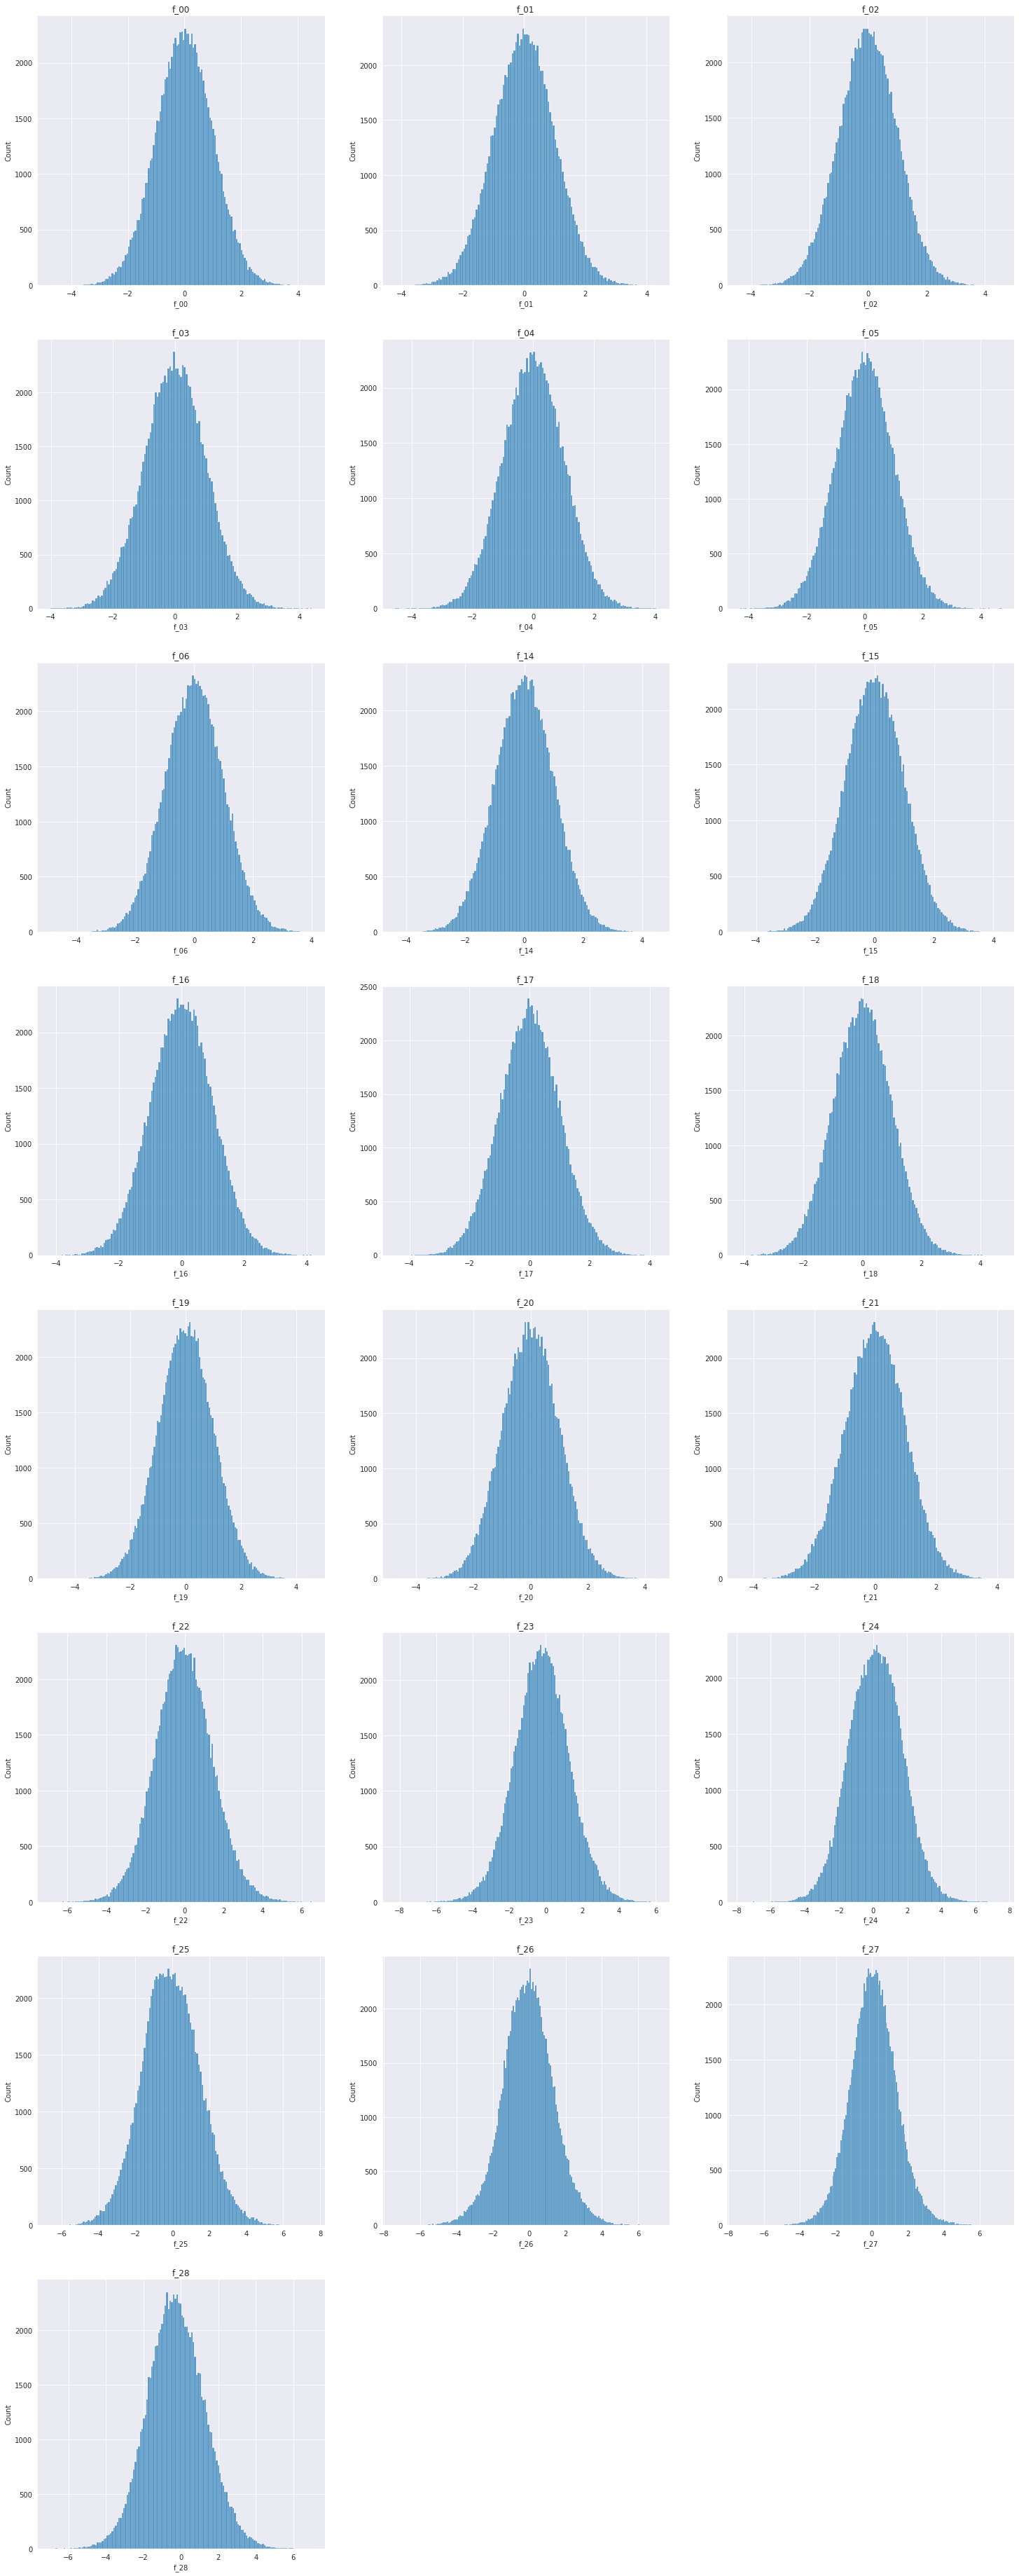

In [5]:
plt.subplots(figsize=(25,75))
for i, column in enumerate(float_cols):
    plt.subplot(9,3,i+1)
    sns.histplot(data=df, x=column)
    plt.title(column)

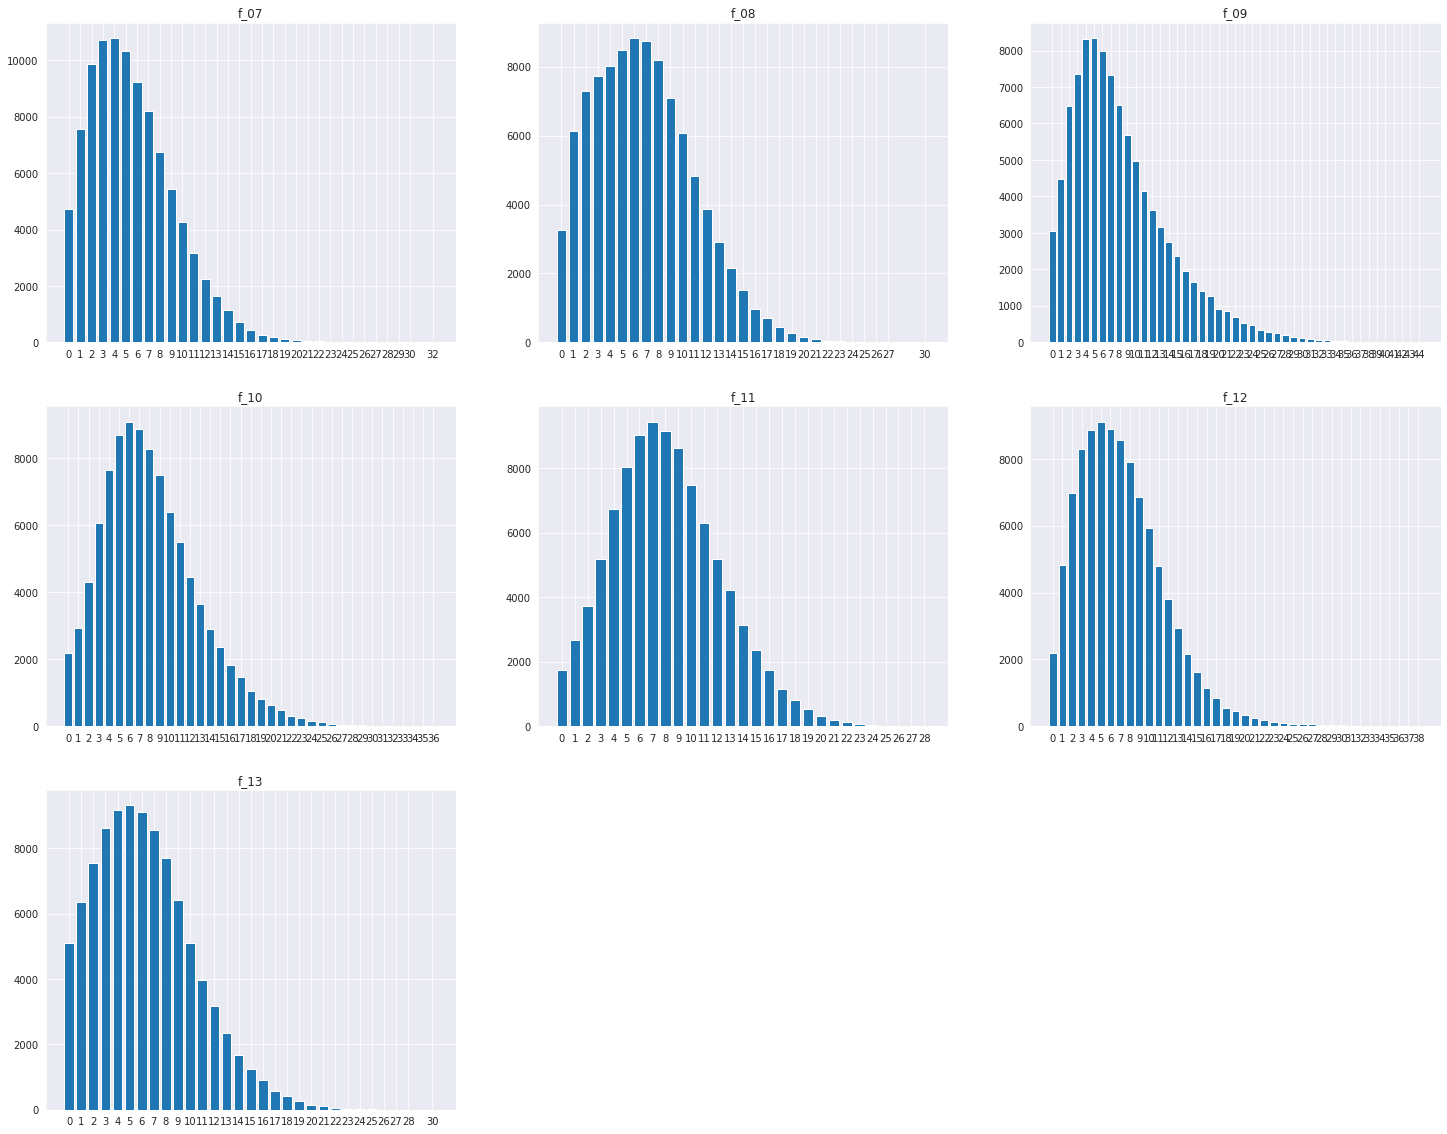

In [6]:
plt.subplots(figsize=(25,20))
for i, column in enumerate(int_cols):
    val_count = df[column].value_counts()
    ax = plt.subplot(3,3,i+1)
    #sns.barplot(x=val_count.index,y=val_count.values)
    ax.bar(val_count.index, val_count.values)
    ax.set_xticks(val_count.index)
    plt.title(column)

In [7]:
def val_count_df(df, column_name, sort=True):
    value_count = df[column_name].value_counts(sort=sort).reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(sort=sort,normalize=True)*100
    value_count = value_count.reset_index()
    return value_count

In [8]:
print("Number of missing values: ", df.isna().sum().sum())

Number of missing values:  0


# Model

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca = PCA(random_state = 10, whiten = True)
X_pca = pca.fit_transform(X_scaled)

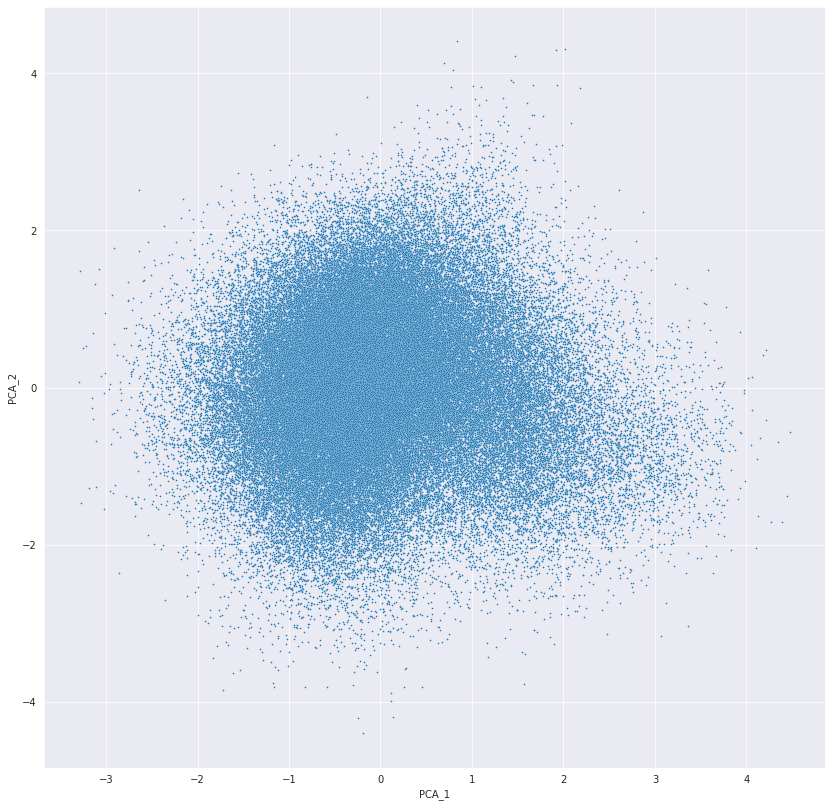

In [10]:
PCA_df = pd.DataFrame({"PCA_1" : X_pca[:,0], "PCA_2" : X_pca[:,1]})
    
plt.figure(figsize=(14, 14))
sns.scatterplot(data = PCA_df, x = "PCA_1", y = "PCA_2", s=3);

## Determining optimal number of clusters

In [11]:
def components_type():
    bic_scores = []
    for covariance in ["spherical", "tied", "diag","full"]:
        gmm = GaussianMixture(n_components=8, covariance_type = covariance, n_init=3, random_state=1)
        gmm.fit(X_scaled)
        bic_score = gmm.bic(X_scaled)
        bic_scores.append(bic_score)
    return bic_scores

In [12]:
def number_of_components(max_n):
    bic_scores = []
    for n in range(1,max_n):
        gmm = GaussianMixture(n_components=n, covariance_type = 'full', n_init=3, random_state=1)
        gmm.fit(X_scaled)
        bic_score = gmm.bic(X_scaled)
        bic_scores.append(bic_score)
    return bic_scores

In [13]:
def components_number_type(max_n):
    bic_scores_cov = []
    for covariance in ["diag"]:#["spherical", "tied", "diag","full"]:
        bic_scores = []
        for n in range(1,max_n):
            gmm = GaussianMixture(n_components=n, covariance_type = covariance, n_init=3, random_state=1)
            gmm.fit(X_scaled)
            bic_score = gmm.bic(X_scaled)
            bic_scores.append(bic_score)
        bic_scores_cov.append(bic_scores)
    return bic_scores_cov
    

In [14]:
bic_scores_cov_num = components_number_type(31)

In [15]:
bic_df = pd.DataFrame(data = bic_scores_cov_num)
#bic_df.index = ["spherical", "tied", "diag","full"]
bic_df.index = ["diag"]
bic_df.columns = range(1,31)

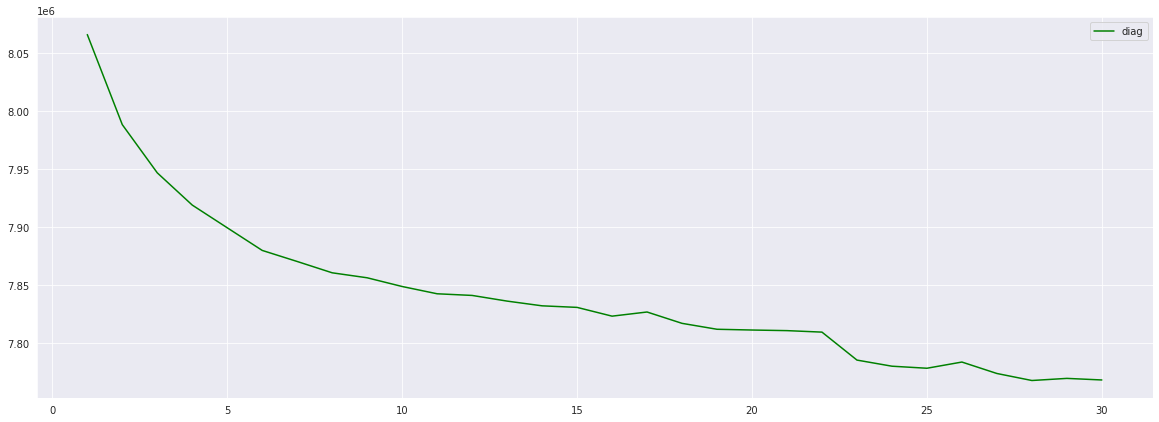

In [16]:
f,ax = plt.subplots(figsize=(20,7))
#type_data =  bic_df.loc["spherical"]
#sns.lineplot(x=type_data.index, y= type_data.values, color="red", label="spherical")
#type_data =  bic_df.loc["tied"]
#sns.lineplot(x=type_data.index, y= type_data.values, color="orange",label="tied")
type_data =  bic_df.loc["diag"]
sns.lineplot(x=type_data.index, y= type_data.values, color="green", label="diag");
#type_data =  bic_df.loc["full"]
#sns.lineplot(x=type_data.index, y= type_data.values, color="blue", label="full");

In [17]:
#bic_scores = number_of_components(41)
#bic_s = pd.Series( bic_scores, range(1,41))
#f,ax = plt.subplots(figsize=(20,10))
#sns.lineplot(x=bic_s.index, y= bic_s.values, color="blue");

## Predictions

In [18]:
gmm = GaussianMixture(n_components=23, covariance_type = 'full', n_init=15, random_state=1)
preds = gmm.fit_predict(X_scaled)

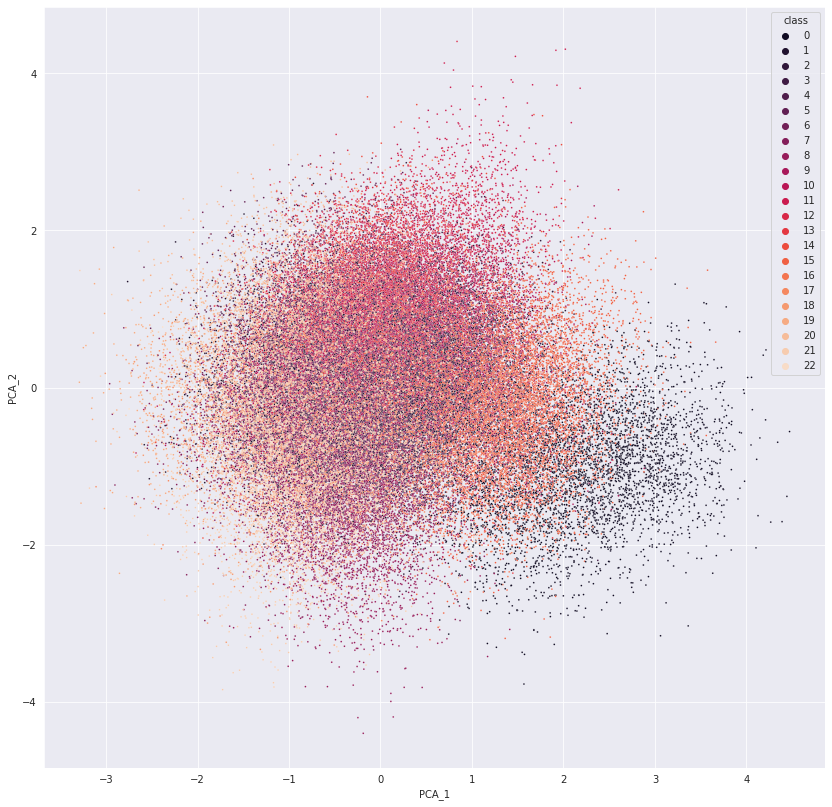

In [19]:
PCA_df["class"] = preds
    
f,ax = plt.subplots(figsize=(14, 14))
sns.scatterplot(data = PCA_df, x = "PCA_1", y = "PCA_2", hue="class", s=3, palette=sns.color_palette("rocket", PCA_df["class"].nunique()));

,class,Value Count,Percentage
0,21,7736,7.893878
1,15,7558,7.712245
2,8,7058,7.202041
3,10,6714,6.851020
4,12,6569,6.703061
5,17,5159,5.264286
6,1,4895,4.994898
7,9,4867,4.966327
8,2,4734,4.830612
9,5,4411,4.501020


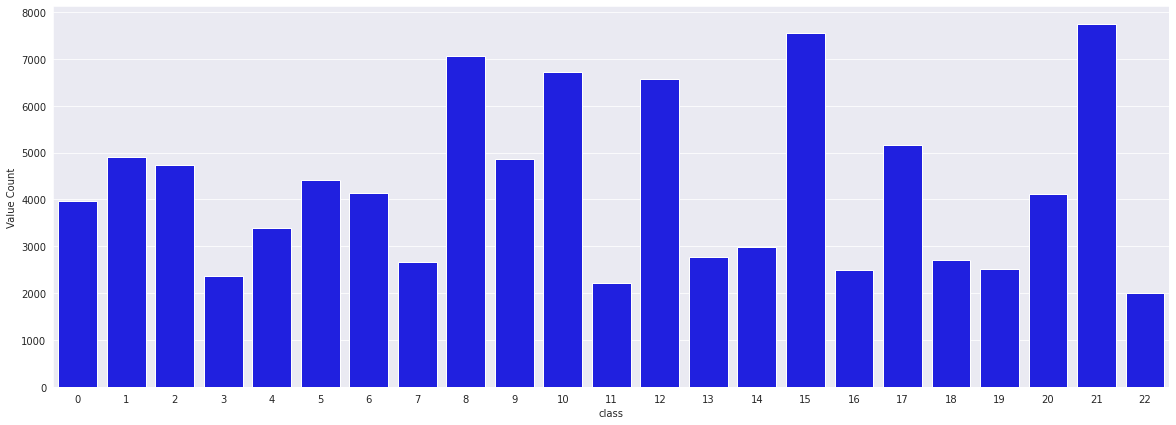

In [20]:
class_count = val_count_df(PCA_df, "class")
display(class_count)
#class_count.set_index("class").plot.pie(y="Value Count", figsize=(10,7), legend=False, ylabel="");
f,ax = plt.subplots(figsize=(20,7))
sns.barplot(data=class_count, x="class", y="Value Count", color="blue");

# Submission

In [21]:
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")

In [22]:
submission["Predicted"] = preds
submission

,Id,Predicted
0,0,6
1,1,17
2,2,3
3,3,15
4,4,10
...,...,...
97995,97995,22
97996,97996,10
97997,97997,9
97998,97998,2


In [23]:
submission.to_csv('submission.csv', index=False)